In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
from pathlib import Path
import pickle
import numpy as np

In [6]:
# display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 100)
%matplotlib inline

### This part aims at cleaning the data and selecting the models for 46A leavetimes stop-to-stop models and applying the to all routes
* The original dataset generated by Notebook 3.0 stopdivide and divided by routes
* add target column: journey time
* delete negative and null rows
* add month, weekday and hour
* merge with trips file to get direction
* merge with openweather historical weather to get weather type
* encode time with cyclical way/ dummy way
* model training, testing and evaluation for : linear regression/random forest/K near neighbour
* hyperparameter tuning for random forest 
* generate pickle

### Summary of data quality plan:

| Variable Names        | Data Description|Data Quality Issue            | Handling Strategy     |
|-------------------|------------------|-------------------|---------------------|
| DAYOFSERVICE               |Day Index |                     | Encode to get month, weekday and hour, drop           |
| TRIPID	             | Trip Index   || Set the first progrnumber each trip each day as a new column start time, drop      |  
| PROGRNUMBER          | Sequential position of the stop point in the trip   | |Do Nothing, select as input           |
| STOPPOINTID                     | Unique stop point code                   |  |Do Nothing, select as input             |
| PLANNEDTIME_ARR              |Planned arrival time at the stop point, in seconds        | |Do Nothing, drop           |
| PLANNEDTIME_DEP        |Planned departure time from the stop point, in seconds         | | Do Nothing, drop         |
| ACTUALTIME_ARR        | Actual arrival time at the stop point, in seconds   | |Do Nothing, drop             |
| ACTUALTIME_DEP             | Actual departure time from the stop point, in seconds       | |Do Nothing, drop        |
| LINEID               | Unique line code  || Merge with trip file to split routes, one model for one LINEID, drop        |
| DIRECTION            | Unique direction code for inbound/outbound |Null values if could not match with trip file |Merge with trip file, select as input|
| START_TIME	               | Starting time for each trip everyday |Negative values, outliers |Map with the ACTUALTIME_ARR for the first stop of each trip everyday, drop              |
| PLANNED_START_TIME           | Planning Starting time for each trip everyday | Negative values, outliers |  Map with the PLANNEDTIME_ARR for the first stop of each trip everyday, drop               |
| JOURNEY_TIME           |   Journey time from current stop to the first stop   |    |Calculate by ACTUALTIME_ARR - START_TIME|
| PLANNED_JOURNEY_TIME           | Planned journey time from current stop to the first stop |        | Calculate by PLANNEDTIME_ARR - START_TIME, drop |
| MONTH                       | range from 1-12    |                  | Encode with DAYYOFSERVICE            |
| WEEKOFDAY              |  range from 0-6, 0 for Monday    |                  | Encode with DAYYOFSERVICE                |
| HOUR         |  range from 0-23               | Hour starts and ends in different day: 12pm        |Encode with DAYYOFSERVICE, reset HOUR to 0, weekday+1            |
| RUSH HOUR|    7-9am and 4-7pm       |              | Decide by the offical document of TRI and historial statistic          |
| WEATHER_MAIN   |      | Null Value                      | Weather type  mist/rain/thunderstorm to one category    |

### read leavetimes data

In [ ]:
cd ~/tmp/data/leavetimes

In [8]:
test_46A = pd.read_csv('leavetimes_46A.csv', sep=",")

In [9]:
test_46A.isnull().sum()

Unnamed: 0         0
DAYOFSERVICE       0
TRIPID             0
PROGRNUMBER        0
STOPPOINTID        0
PLANNEDTIME_ARR    0
PLANNEDTIME_DEP    0
ACTUALTIME_ARR     0
ACTUALTIME_DEP     0
VEHICLEID          0
LINEID             0
dtype: int64

### First way to get journey time: add the infomation of previous stop, delete the first programnum of each trip everyday

In [22]:
'''
This function is to add columns for two closed stops model: eg. 2-3, 4-5 
stop interval to distingush stops not adjacent and remove them
'''

'\nThis function is to add columns for two closed stops model: eg. 2-3, 4-5 \n'

In [23]:
# def add_columns(x):
#     # drop useless columns
#     x = x.drop(columns=['Unnamed: 0','PLANNEDTIME_DEP','ACTUALTIME_DEP','VEHICLEID'])
#     # sort by tripid
#     x = x.sort_values(by=['DAYOFSERVICE','TRIPID','PROGRNUMBER'])
#     x= x.reset_index(drop=True)
#     # columns of previous program number
#     x['PRE_PROGRNUMBER'] = x['PROGRNUMBER']
#     x['PRE_PROGRNUMBER'] = x['PRE_PROGRNUMBER'].shift(1)
#     # previous stopid
#     x['PRE_STOPPOINTID'] = x['STOPPOINTID']
#     x['PRE_STOPPOINTID'] = x['PRE_STOPPOINTID'].shift(1)
#     # previous planned and actual arrival time
#     x['PRE_PLANNEDTIME_ARR'] = x['PLANNEDTIME_ARR']
#     x['PRE_PLANNEDTIME_ARR'] = x['PRE_PLANNEDTIME_ARR'].shift(1)
#     x['PRE_ACTUALTIME_ARR'] = x['ACTUALTIME_ARR']
#     x['PRE_ACTUALTIME_ARR'] = x['PRE_ACTUALTIME_ARR'].shift(1)
#     # some programnum starts from 2, so couldn't just delete 1
#     # x = x.loc[x['PROGRNUMBER'] != 1]
#     # delete the first duplicate programnum everyday
#     first_rows = x.drop_duplicates(subset=['TRIPID','DAYOFSERVICE'], keep='first')
#     x = pd.merge(x, first_rows, how='left', indicator=True).query("_merge=='left_only'").drop('_merge', 1)
#     # journey time from the previous stop to current stop
#     x['JOURNEY_TIME'] = x['ACTUALTIME_ARR'] - x['PRE_ACTUALTIME_ARR']
#     x['PLANNED_JOURNEY_TIME'] = x['PLANNEDTIME_ARR'] - x['PRE_PLANNEDTIME_ARR']
#     # stop interval, some data was not constant
#     x['STOP_INTERVAL'] = x['PROGRNUMBER'] - x['PRE_PROGRNUMBER']
#     x = x.reset_index(drop=True)
#     return x

### Second way to get journey time: add the infomation of starting stop, calculatr the journey time for each stop

In [1]:
'''
This function is to add columns for the beginning to one exact stops model: eg. first to second stop, first to fifth stop 
start time as a new column to distinguish the starting of each trip each day, used to calculate journey time
would prefer this function, reasons:
1. much higher accuracy
2. easy to use for backend, get two stopid and then minus
'''

'\nThis function is to add columns for the beginning to one exact stops model: eg. first to second stop, first to fifth stop \nstart time as a new column to distinguish the starting of each trip each day, used to calculate journey time\nwould prefer this function, reasons:\n1. much higher accuracy\n2. easy to use for backend, get two stopid and then minus\n'

In [26]:
# delete the first rows and it related rows that there's not starting with 1
def add_columns(x):
    # drop useless columns
    x = x.drop(columns=['Unnamed: 0','VEHICLEID'])
    x = x.sort_values(by=['DAYOFSERVICE','TRIPID','PROGRNUMBER'])
    x = x.reset_index(drop=True)
    x["DAYOFSERVICE"] =  x["DAYOFSERVICE"].astype("datetime64[ns]")
    x['LINEID'] = x['LINEID'].astype('object')
    # delete the first duplicate programnum everyday, set its start time for each line of this tripid
    first_rows = x.drop_duplicates(subset=['TRIPID','DAYOFSERVICE'], keep='first')
    first_rows['START_TIME'] = first_rows['ACTUALTIME_DEP']
    first_rows['PLANNED_START_TIME'] = first_rows['PLANNEDTIME_DEP']
    first_rows['flag'] = 0
    first_rows['flag'].loc[first_rows['PROGRNUMBER'] == 1] = 1
    first_rows = first_rows[['DAYOFSERVICE','TRIPID','LINEID','START_TIME','PLANNED_START_TIME','flag']]
    x = pd.merge(x, first_rows,on=['DAYOFSERVICE','TRIPID','LINEID'], how='left')
    x = x.loc[x['flag'] == 1]
    # calculate the journey time 
    x['JOURNEY_TIME'] = x['ACTUALTIME_ARR'] - x['START_TIME']
    x['PLANNED_JOURNEY_TIME'] = x['PLANNEDTIME_ARR'] - x['PLANNED_START_TIME']
    x = x.drop(columns=['flag'])
    x = x.reset_index(drop=True)
    return x

In [27]:
test_46A = add_columns(test_46A)

/tmp/ipykernel_27359/2283289040.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_rows['START_TIME'] = first_rows['ACTUALTIME_DEP']
/tmp/ipykernel_27359/2283289040.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_rows['PLANNED_START_TIME'] = first_rows['PLANNEDTIME_DEP']
/tmp/ipykernel_27359/2283289040.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [28]:
test_46A

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME
0,2018-01-01,5955568,1,2039,41400,41400,41402,41402,46A,41402,41400,0,0
1,2018-01-01,5955568,2,2040,41464,41464,41491,41569,46A,41402,41400,89,64
2,2018-01-01,5955568,3,2041,41544,41544,41636,41655,46A,41402,41400,234,144
3,2018-01-01,5955568,4,2042,41642,41642,41719,41729,46A,41402,41400,317,242
4,2018-01-01,5955568,5,2043,41658,41658,41745,41745,46A,41402,41400,343,258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213540,2018-12-31,8590439,45,2018,72825,72825,72553,72553,46A,69452,69600,3101,3225
4213541,2018-12-31,8590439,46,2019,72851,72851,72571,72571,46A,69452,69600,3119,3251
4213542,2018-12-31,8590439,47,2020,72882,72882,72593,72607,46A,69452,69600,3141,3282
4213543,2018-12-31,8590439,48,2021,72905,72905,72631,72759,46A,69452,69600,3179,3305


## add direction with trip.csv
because the total leavetimes is too huge so didn't conclude direction while split the file  

In [29]:
cd ~/tmp/data

/home/team9/tmp/data


In [30]:
trips = pd.read_csv('rt_trips_DB_2018.txt', sep=";", parse_dates=[0],usecols=['DAYOFSERVICE', 'TRIPID', 'LINEID','DIRECTION'])

In [31]:
trips

,DAYOFSERVICE,TRIPID,LINEID,DIRECTION
0,2018-02-07,6253783,68,1
1,2018-02-07,6262138,25B,2
2,2018-02-07,6254942,45A,2
3,2018-02-07,6259460,25A,1
4,2018-02-07,6253175,14,1
...,...,...,...,...
2182632,2018-05-14,6765849,123,2
2182633,2018-05-14,6765469,75,1
2182634,2018-05-14,6765486,33D,2
2182635,2018-05-14,6764987,70,1


In [32]:
test_46A.dtypes

DAYOFSERVICE            datetime64[ns]
TRIPID                           int64
PROGRNUMBER                      int64
STOPPOINTID                      int64
PLANNEDTIME_ARR                  int64
PLANNEDTIME_DEP                  int64
ACTUALTIME_ARR                   int64
ACTUALTIME_DEP                   int64
LINEID                          object
START_TIME                       int64
PLANNED_START_TIME               int64
JOURNEY_TIME                     int64
PLANNED_JOURNEY_TIME             int64
dtype: object

In [33]:
trips.dtypes

DAYOFSERVICE    datetime64[ns]
TRIPID                   int64
LINEID                  object
DIRECTION                int64
dtype: object

In [34]:
test_46A = pd.merge(test_46A,trips,on=['DAYOFSERVICE','TRIPID','LINEID'],how='left')

In [35]:
test_46A

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION
0,2018-01-01,5955568,1,2039,41400,41400,41402,41402,46A,41402,41400,0,0,2
1,2018-01-01,5955568,2,2040,41464,41464,41491,41569,46A,41402,41400,89,64,2
2,2018-01-01,5955568,3,2041,41544,41544,41636,41655,46A,41402,41400,234,144,2
3,2018-01-01,5955568,4,2042,41642,41642,41719,41729,46A,41402,41400,317,242,2
4,2018-01-01,5955568,5,2043,41658,41658,41745,41745,46A,41402,41400,343,258,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213540,2018-12-31,8590439,45,2018,72825,72825,72553,72553,46A,69452,69600,3101,3225,1
4213541,2018-12-31,8590439,46,2019,72851,72851,72571,72571,46A,69452,69600,3119,3251,1
4213542,2018-12-31,8590439,47,2020,72882,72882,72593,72607,46A,69452,69600,3141,3282,1
4213543,2018-12-31,8590439,48,2021,72905,72905,72631,72759,46A,69452,69600,3179,3305,1


## check outliers and delete rows
the second way without stop interval columns

In [36]:
#### how many rows journey time is negative
# 67 rows, check and they are all errors, drop
test_46A[(test_46A.JOURNEY_TIME <= 0)]
#test_46A[(test_46A.PLANNED_JOURNEY_TIME <=0)]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION
0,2018-01-01,5955568,1,2039,41400,41400,41402,41402,46A,41402,41400,0,0,2
63,2018-01-01,5955569,1,807,46200,46200,46227,46227,46A,46227,46200,0,0,1
122,2018-01-01,5955570,1,2039,51000,51000,50961,50961,46A,50961,51000,0,0,2
185,2018-01-01,5955571,1,807,56400,56400,56346,56346,46A,56346,56400,0,0,1
244,2018-01-01,5955572,1,2039,61200,61200,61146,61146,46A,61146,61200,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213256,2018-12-31,8590435,1,807,47400,47400,47341,47341,46A,47341,47400,0,0,1
4213315,2018-12-31,8590436,1,2039,52800,52800,53400,53400,46A,53400,52800,0,0,2
4213376,2018-12-31,8590437,1,807,58800,58800,58774,58774,46A,58774,58800,0,0,1
4213435,2018-12-31,8590438,1,2039,64200,64200,64242,64242,46A,64242,64200,0,0,2


In [37]:
#### how many rows null
test_46A.isnull().sum()
#test_46A.dropna(axis=0, how='any', inplace=True)

DAYOFSERVICE            0
TRIPID                  0
PROGRNUMBER             0
STOPPOINTID             0
PLANNEDTIME_ARR         0
PLANNEDTIME_DEP         0
ACTUALTIME_ARR          0
ACTUALTIME_DEP          0
LINEID                  0
START_TIME              0
PLANNED_START_TIME      0
JOURNEY_TIME            0
PLANNED_JOURNEY_TIME    0
DIRECTION               0
dtype: int64

In [38]:
#### how many rows stop interval != 1
# test_46A[(test_46A.STOP_INTERVAL <=0)]

In [39]:
# 38135 rows, not sure if delete or not
# test_46A[(test_46A.STOP_INTERVAL != 1)]

In [40]:
def remove_rows(x):
    # remove rows with negative journey time
    x =  x.drop(index = x[(x.JOURNEY_TIME <=0)].index.tolist())
    x =  x.drop(index = x[(x.PLANNED_JOURNEY_TIME <=0)].index.tolist())
    # remove null values although didn't exist in test set
    x.dropna(axis=1, how='all', inplace=True)
    x.dropna(axis=0, how='any', inplace=True)
    # remove stop interval != 1 which is not continuous
    #x = x.drop(index = x[(x.STOP_INTERVAL != 1)].index.tolist())
    x = x.reset_index(drop=True)
    return x

In [41]:
test_46A = remove_rows(test_46A)

In [42]:
test_46A

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION
0,2018-01-01,5955568,2,2040,41464,41464,41491,41569,46A,41402,41400,89,64,2
1,2018-01-01,5955568,3,2041,41544,41544,41636,41655,46A,41402,41400,234,144,2
2,2018-01-01,5955568,4,2042,41642,41642,41719,41729,46A,41402,41400,317,242,2
3,2018-01-01,5955568,5,2043,41658,41658,41745,41745,46A,41402,41400,343,258,2
4,2018-01-01,5955568,6,2044,41681,41681,41764,41778,46A,41402,41400,362,281,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4140200,2018-12-31,8590439,45,2018,72825,72825,72553,72553,46A,69452,69600,3101,3225,1
4140201,2018-12-31,8590439,46,2019,72851,72851,72571,72571,46A,69452,69600,3119,3251,1
4140202,2018-12-31,8590439,47,2020,72882,72882,72593,72607,46A,69452,69600,3141,3282,1
4140203,2018-12-31,8590439,48,2021,72905,72905,72631,72759,46A,69452,69600,3179,3305,1


## add month, hour, dayofweek

In [43]:
def add_date(x):
#     x["DAYOFSERVICE"] =  x["DAYOFSERVICE"].astype("datetime64[ns]") 
    x['MONTH'] = x['DAYOFSERVICE'].dt.month
    x['DAYOFWEEK'] = x['DAYOFSERVICE'].dt.weekday
    x['HOUR'] = x['ACTUALTIME_ARR'].apply(lambda row: row//3600)
    # if 24 then change to midnight and increase day by 1
    x['DAYOFSERVICE'].loc[x['HOUR'] >= 24] = x['DAYOFSERVICE']+ dt.timedelta(days=1)
    x['HOUR'].loc[x['HOUR'] >= 24] -= 24
    x = x.drop(columns=['TRIPID','PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP'])
    return x

In [44]:
test_46A = add_date(test_46A)

/tmp/ipykernel_27359/3114941901.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['DAYOFSERVICE'].loc[x['HOUR'] >= 24] = x['DAYOFSERVICE']+ dt.timedelta(days=1)
/tmp/ipykernel_27359/3114941901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['HOUR'].loc[x['HOUR'] >= 24] -= 24


In [45]:
test_46A.loc[test_46A['HOUR']>23]

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR


In [46]:
test_46A

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR
0,2018-01-01,2,2040,46A,41402,41400,89,64,2,1,0,11
1,2018-01-01,3,2041,46A,41402,41400,234,144,2,1,0,11
2,2018-01-01,4,2042,46A,41402,41400,317,242,2,1,0,11
3,2018-01-01,5,2043,46A,41402,41400,343,258,2,1,0,11
4,2018-01-01,6,2044,46A,41402,41400,362,281,2,1,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
4140200,2018-12-31,45,2018,46A,69452,69600,3101,3225,1,12,0,20
4140201,2018-12-31,46,2019,46A,69452,69600,3119,3251,1,12,0,20
4140202,2018-12-31,47,2020,46A,69452,69600,3141,3282,1,12,0,20
4140203,2018-12-31,48,2021,46A,69452,69600,3179,3305,1,12,0,20


In [47]:
# looking at correlations between weather features the target feature
correlations = test_46A.corr()
correlations

,PROGRNUMBER,STOPPOINTID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR
PROGRNUMBER,1.000000,-0.033832,-0.003270,-0.003464,0.909715,0.935193,0.057468,-0.001944,0.004178,0.063105
STOPPOINTID,-0.033832,1.000000,0.006326,0.006419,-0.016211,-0.018249,-0.007068,0.009485,0.000735,0.001885
START_TIME,-0.003270,0.006326,1.000000,0.999943,-0.075263,-0.080132,-0.012874,0.000191,0.080963,0.974079
PLANNED_START_TIME,-0.003464,0.006419,0.999943,1.000000,-0.075042,-0.080232,-0.014207,-0.000038,0.080672,0.974043
JOURNEY_TIME,0.909715,-0.016211,-0.075263,-0.075042,1.000000,0.968148,-0.116364,0.013465,-0.039917,0.002691
PLANNED_JOURNEY_TIME,0.935193,-0.018249,-0.080132,-0.080232,0.968148,1.000000,-0.113886,-0.006364,-0.058714,-0.003244
DIRECTION,0.057468,-0.007068,-0.012874,-0.014207,-0.116364,-0.113886,1.000000,0.002352,0.002722,-0.016734
MONTH,-0.001944,0.009485,0.000191,-0.000038,0.013465,-0.006364,0.002352,1.000000,0.026978,0.000916
DAYOFWEEK,0.004178,0.000735,0.080963,0.080672,-0.039917,-0.058714,0.002722,0.026978,1.000000,0.075034
HOUR,0.063105,0.001885,0.974079,0.974043,0.002691,-0.003244,-0.016734,0.000916,0.075034,1.000000


In [48]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
def draw_correlations(df):
    sns.set(style="white")
    # Calculate correlation of all pairs of continuous features
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 20))

    # Generate a custom colormap - blue and red
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
    square=True, xticklabels=True, yticklabels=True,
    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 45)

/tmp/ipykernel_27359/2172495457.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


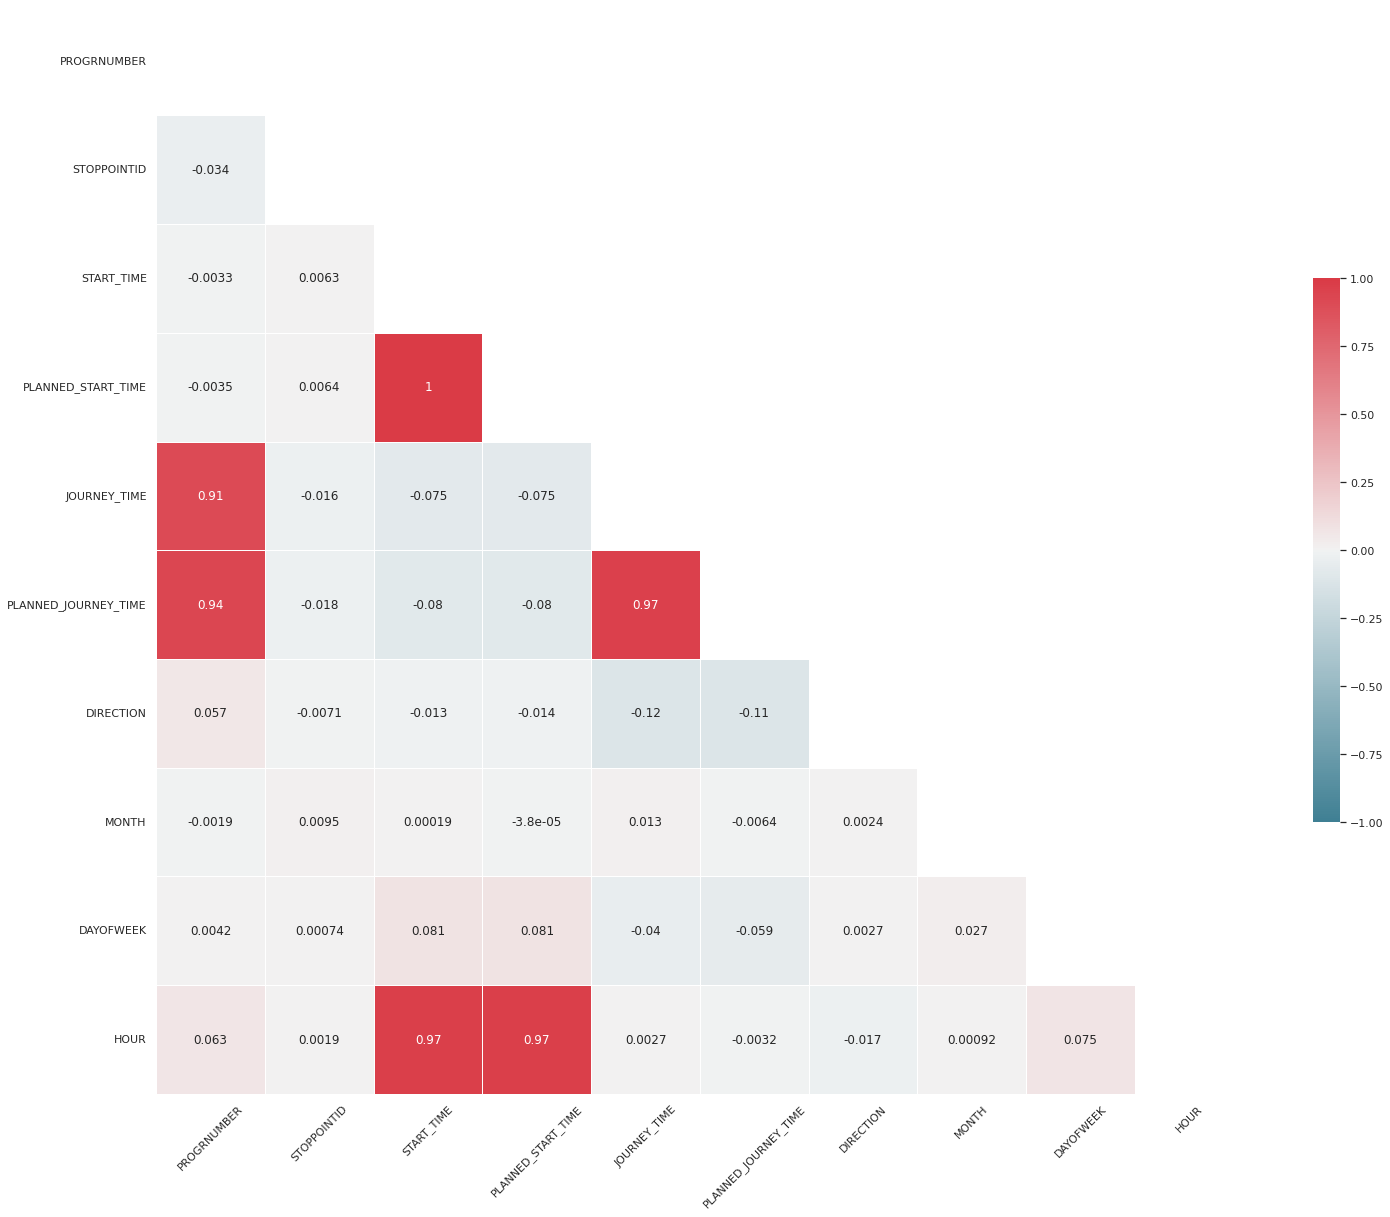

In [49]:
draw_correlations(test_46A)

In [50]:
test_46A.dtypes

DAYOFSERVICE            datetime64[ns]
PROGRNUMBER                      int64
STOPPOINTID                      int64
LINEID                          object
START_TIME                       int64
PLANNED_START_TIME               int64
JOURNEY_TIME                     int64
PLANNED_JOURNEY_TIME             int64
DIRECTION                        int64
MONTH                            int64
DAYOFWEEK                        int64
HOUR                             int64
dtype: object

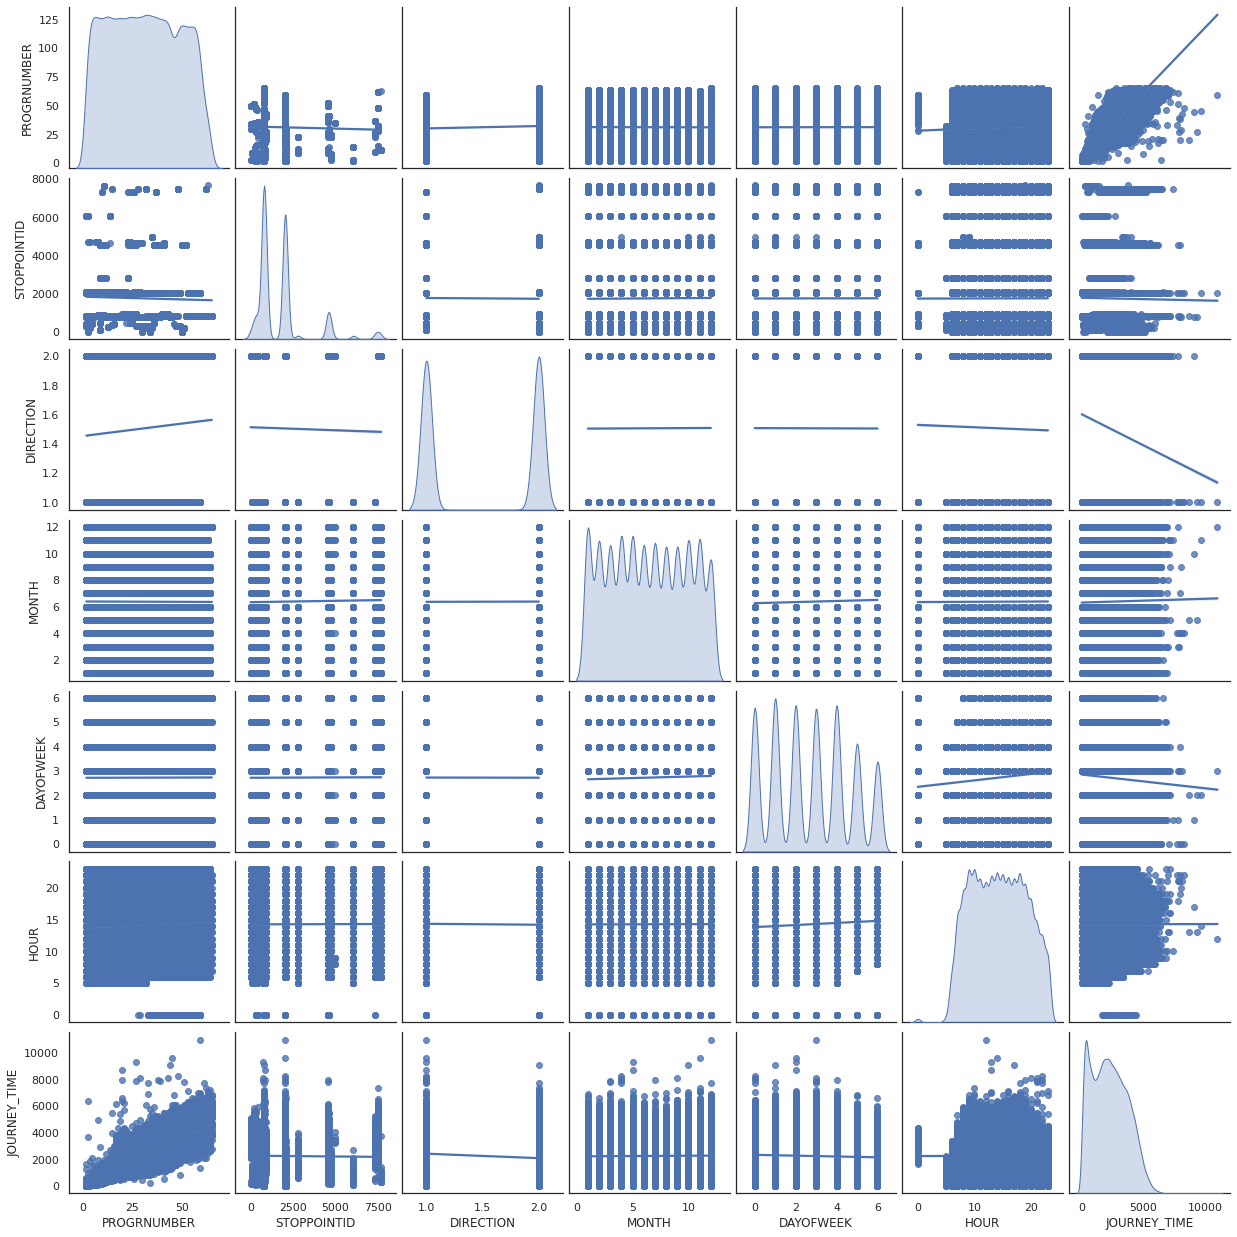

In [51]:
# take long time to run
sns.pairplot(test_46A.sample(100000), kind="reg",diag_kind="kde", 
              vars=['PROGRNUMBER','STOPPOINTID','DIRECTION','MONTH','DAYOFWEEK','HOUR','JOURNEY_TIME']) 

## clean the weather

In [52]:
cd ~/tmp/data

/home/team9/tmp/data


In [53]:
weather = pd.read_csv('Custom_location_53_345035_-6_267261_62b5c8e6c91d98000ba01ceb.csv', parse_dates=[1])

In [54]:
weather

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1483228800,2017-01-01 00:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,5.39,9999.0,4.35,1.78,5.36,6.56,1019,NaN,NaN,93,5.10,330,NaN,2.30,NaN,NaN,NaN,75,501,Rain,moderate rain,10n
1,1483232400,2017-01-01 01:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,5.39,9999.0,4.35,2.28,5.36,5.56,1019,NaN,NaN,93,4.10,310,NaN,1.51,NaN,NaN,NaN,75,501,Rain,moderate rain,10n
2,1483236000,2017-01-01 02:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,5.39,9999.0,4.35,2.28,5.36,5.56,1019,NaN,NaN,93,4.10,320,NaN,0.64,NaN,NaN,NaN,75,500,Rain,light rain,10n
3,1483239600,2017-01-01 03:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,4.39,9999.0,3.36,0.04,4.36,5.56,1019,NaN,NaN,93,6.20,330,NaN,0.17,NaN,NaN,NaN,75,500,Rain,light rain,10n
4,1483243200,2017-01-01 04:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,4.39,9999.0,2.42,0.04,4.36,4.56,1019,NaN,NaN,87,6.20,330,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27181,1577818800,2019-12-31 19:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,9.33,9999.0,6.42,9.33,8.87,9.56,1030,NaN,NaN,82,0.45,96,2.68,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
27182,1577822400,2019-12-31 20:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,8.81,9999.0,6.09,7.02,8.10,9.56,1030,NaN,NaN,83,3.10,130,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
27183,1577826000,2019-12-31 21:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,7.86,9999.0,5.33,7.86,6.53,8.51,1030,NaN,NaN,84,0.45,136,1.79,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
27184,1577829600,2019-12-31 22:00:00 +0000 UTC,0,Custom location,53.345035,-6.267261,7.49,9999.0,4.09,7.49,5.53,8.51,1029,NaN,NaN,79,0.45,176,1.79,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


In [55]:
weather.isnull().sum()

dt                         0
dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
visibility                49
dew_point                  0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              27186
grnd_level             27186
humidity                   0
wind_speed                 0
wind_deg                   0
wind_gust              20079
rain_1h                21315
rain_3h                27186
snow_1h                27105
snow_3h                27186
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64

#### need more analysis here but basically just take temp and weather main

In [56]:
def date_from_epoch(x):
    y = dt.datetime.fromtimestamp (x).strftime('%Y-%m-%d')
    return y   

# weather['DAYOFSERVICE'] = weather['dt'].apply(lambda x: date_from_epoch(x))

In [57]:
def round_epoch_hour(x):
    day = x // 86400
    day = day * 86400
    time = x - day
    round_time = time // 3600
    return round_time
# weather['HOUR'] = weather['dt'].apply(lambda x: round_epoch_hour(x))

In [58]:
def clean_weather(x):
    # x = x[['dt','temp','weather_main']]
    x = x.drop(columns=['dt_iso','timezone','city_name','lat','lon','sea_level','grnd_level','wind_gust','rain_1h','rain_3h','snow_1h','snow_3h'])
    x['DAYOFSERVICE'] = x['dt'].apply(lambda x: date_from_epoch(x))
    x["DAYOFSERVICE"] =  x["DAYOFSERVICE"].astype("datetime64[ns]") 
    x['HOUR'] = x['dt'].apply(lambda x: round_epoch_hour(x))
    return x

In [59]:
clean_weather(weather)

,dt,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,DAYOFSERVICE,HOUR
0,1483228800,5.39,9999.0,4.35,1.78,5.36,6.56,1019,93,5.10,330,75,501,Rain,moderate rain,10n,2017-01-01,0
1,1483232400,5.39,9999.0,4.35,2.28,5.36,5.56,1019,93,4.10,310,75,501,Rain,moderate rain,10n,2017-01-01,1
2,1483236000,5.39,9999.0,4.35,2.28,5.36,5.56,1019,93,4.10,320,75,500,Rain,light rain,10n,2017-01-01,2
3,1483239600,4.39,9999.0,3.36,0.04,4.36,5.56,1019,93,6.20,330,75,500,Rain,light rain,10n,2017-01-01,3
4,1483243200,4.39,9999.0,2.42,0.04,4.36,4.56,1019,87,6.20,330,75,803,Clouds,broken clouds,04n,2017-01-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27181,1577818800,9.33,9999.0,6.42,9.33,8.87,9.56,1030,82,0.45,96,75,803,Clouds,broken clouds,04n,2019-12-31,19
27182,1577822400,8.81,9999.0,6.09,7.02,8.10,9.56,1030,83,3.10,130,90,804,Clouds,overcast clouds,04n,2019-12-31,20
27183,1577826000,7.86,9999.0,5.33,7.86,6.53,8.51,1030,84,0.45,136,90,804,Clouds,overcast clouds,04n,2019-12-31,21
27184,1577829600,7.49,9999.0,4.09,7.49,5.53,8.51,1029,79,0.45,176,75,803,Clouds,broken clouds,04n,2019-12-31,22


In [60]:
weather = clean_weather(weather)

### Correlations for weather

In [61]:
weather.loc[weather['HOUR']>23]

,dt,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,DAYOFSERVICE,HOUR


/tmp/ipykernel_27359/2172495457.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


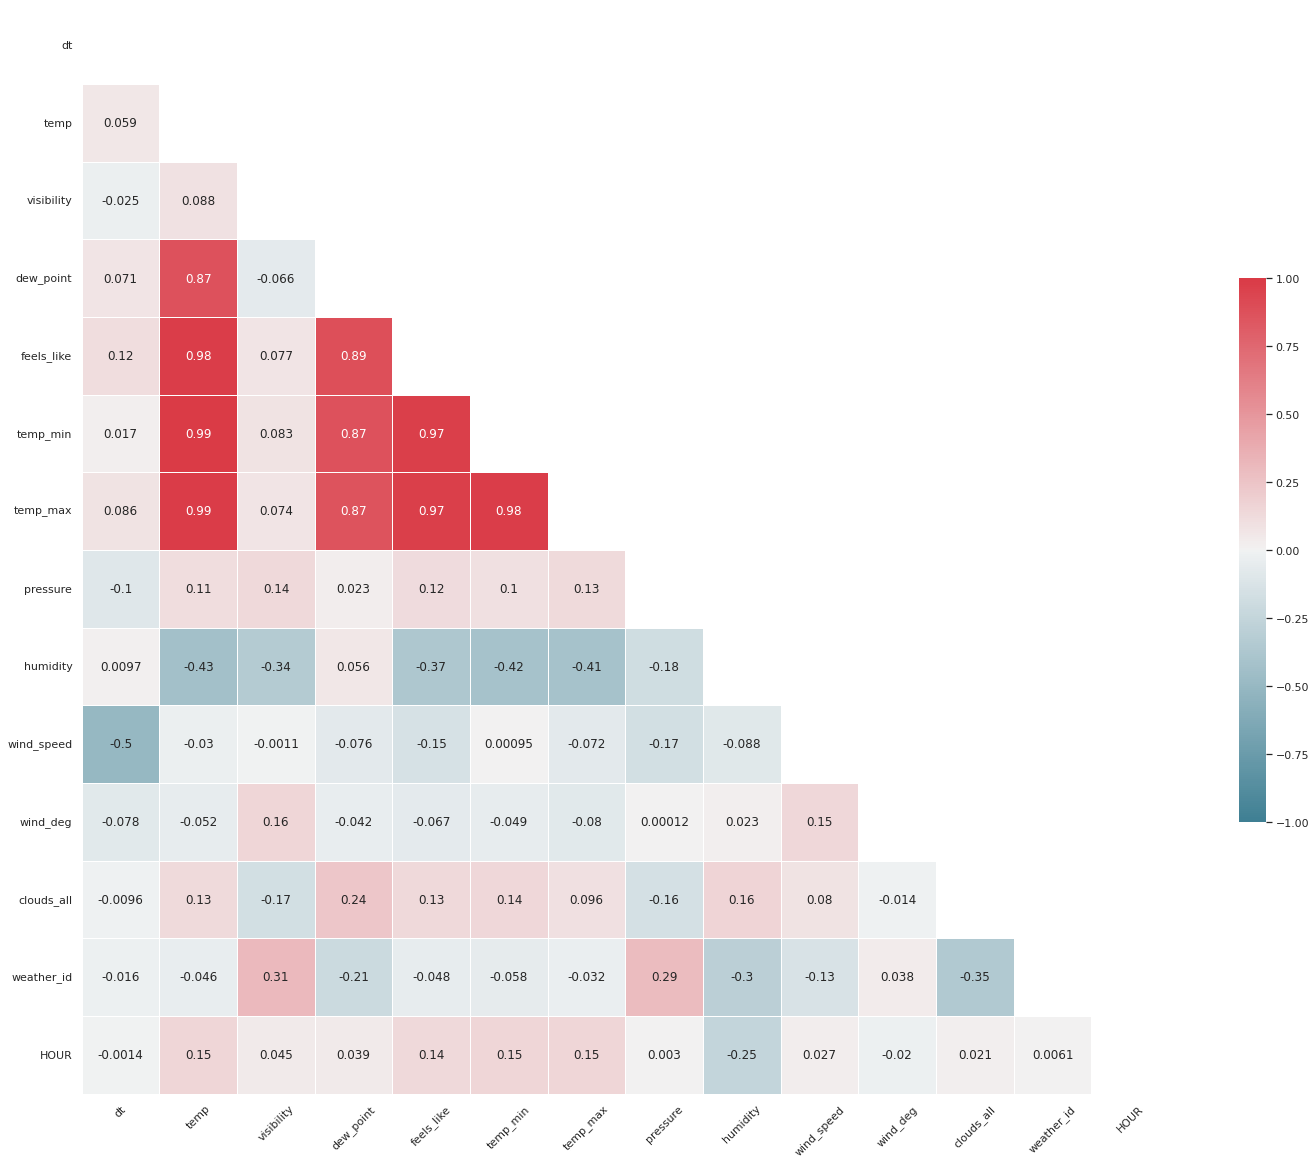

In [62]:
draw_correlations(weather)

## merge the leavetimes with weather

In [63]:
test_46A = pd.merge(test_46A, weather, on=['DAYOFSERVICE', 'HOUR'], how='left')

In [64]:
test_46A

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR,dt,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2018-01-01,2,2040,46A,41402,41400,89,64,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d
1,2018-01-01,3,2041,46A,41402,41400,234,144,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d
2,2018-01-01,4,2042,46A,41402,41400,317,242,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d
3,2018-01-01,5,2043,46A,41402,41400,343,258,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d
4,2018-01-01,6,2044,46A,41402,41400,362,281,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280120,2018-12-31,45,2018,46A,69452,69600,3101,3225,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n
4280121,2018-12-31,46,2019,46A,69452,69600,3119,3251,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n
4280122,2018-12-31,47,2020,46A,69452,69600,3141,3282,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n
4280123,2018-12-31,48,2021,46A,69452,69600,3179,3305,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n


In [65]:
test_46A.dropna(axis=0, how='any', inplace=True)

## encode time

### First way to encode: dummy

https://www.tomtom.com/en_gb/traffic-index/dublin-traffic/  
https://www.dublinpublictransport.ie/dublin-buses#:~:text=Frequency%20of%20buses%20varies%20by,9am%20and%205pm%2D7pm).  
https://www.irishrail.ie/en-ie/faqs/when-should-i-travel  
decide to take 7-9am 4-7pm in workday for rush hour 2018, although after covid in the morning the rush hour doesn't affect too much

In [66]:
def cal_rush(df):
    df['rush_hour'] = 0
    rush_hour = [7,8,9,16,17,18,19]
    weekends = [5,6]
    for i in rush_hour:
        df['rush_hour'].loc[df['HOUR'] == i] = 1
    for j in weekends:
        df['rush_hour'].loc[df['DAYOFWEEK'] == j] = 0
    return df

In [67]:
test_46A = cal_rush(test_46A)

/tmp/ipykernel_27359/3461913905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rush_hour'].loc[df['HOUR'] == i] = 1
/tmp/ipykernel_27359/3461913905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rush_hour'].loc[df['DAYOFWEEK'] == j] = 0


In [68]:
# def dummy_feature(x):
#     # add rush hour
#     x = cal_rush(x)
#     # convert weather type
#     x['weather_main'] = x['weather_main'].apply(lambda x: 1 if (x == "Rain" or x == "Mist" or x == "Thunderstorm") else 0)
#     # add month dummies
#     monthDummies = pd.get_dummies(x['MONTH'], prefix='MONTH', drop_first=False)
#     x = pd.concat([x, monthDummies], axis=1)
#     # add weekday dummies
#     dayDummies = pd.get_dummies(x['DAYOFWEEK'], prefix='DAYOFWEEK', drop_first=False)
#     x = pd.concat([x, dayDummies], axis=1)
#     # add hour dummies
#     hourDummies = pd.get_dummies(x['HOUR'], prefix='HOUR', drop_first=False)
#     x = pd.concat([x, hourDummies], axis=1)
#     return x

In [69]:
# test_46A = dummy_feature(test_46A)

### Second way to encode: cyclical 
an industry way to encode time by kaggle tutorial:  
https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

In [70]:
# def cyclical_feature(x):
#     # add rush hour
#     x = cal_rush(x)
#     x['weather_main'] = x['weather_main'].apply(lambda x: 1 if (x == "Rain" or x == "Mist" or x == "Thunderstorm") else 0)
#     x['month_sin'] = np.sin(2 * np.pi * x['MONTH']/12.0)
#     x['month_cos'] = np.cos(2 * np.pi * x['MONTH']/12.0)
#     x['week_sin'] = np.sin(2 * np.pi * x['DAYOFWEEK']/6.0)
#     x['week_cos'] = np.cos(2 * np.pi * x['DAYOFWEEK']/6.0)
#     x['hour_sin'] = np.sin(2 * np.pi * x['HOUR']/23.0)
#     x['hour_cos'] = np.cos(2 * np.pi * x['HOUR']/23.0)
#     return x

In [71]:
# test_46A = cyclical_feature(test_46A)

In [72]:
test_46A

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,LINEID,START_TIME,PLANNED_START_TIME,JOURNEY_TIME,PLANNED_JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR,dt,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,rush_hour
0,2018-01-01,2,2040,46A,41402,41400,89,64,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d,0
1,2018-01-01,3,2041,46A,41402,41400,234,144,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d,0
2,2018-01-01,4,2042,46A,41402,41400,317,242,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d,0
3,2018-01-01,5,2043,46A,41402,41400,343,258,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d,0
4,2018-01-01,6,2044,46A,41402,41400,362,281,2,1,0,11,1.514804e+09,6.39,9999.0,3.37,0.88,6.36,6.56,993.0,81.0,12.40,260.0,40.0,802.0,Clouds,scattered clouds,03d,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280120,2018-12-31,45,2018,46A,69452,69600,3101,3225,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n,0
4280121,2018-12-31,46,2019,46A,69452,69600,3119,3251,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n,0
4280122,2018-12-31,47,2020,46A,69452,69600,3141,3282,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n,0
4280123,2018-12-31,48,2021,46A,69452,69600,3179,3305,1,12,0,20,1.546286e+09,9.86,9999.0,6.39,9.86,9.21,10.56,1034.0,79.0,0.45,312.0,75.0,803.0,Clouds,broken clouds,04n,0


## choose input for the models

/tmp/ipykernel_27359/2172495457.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


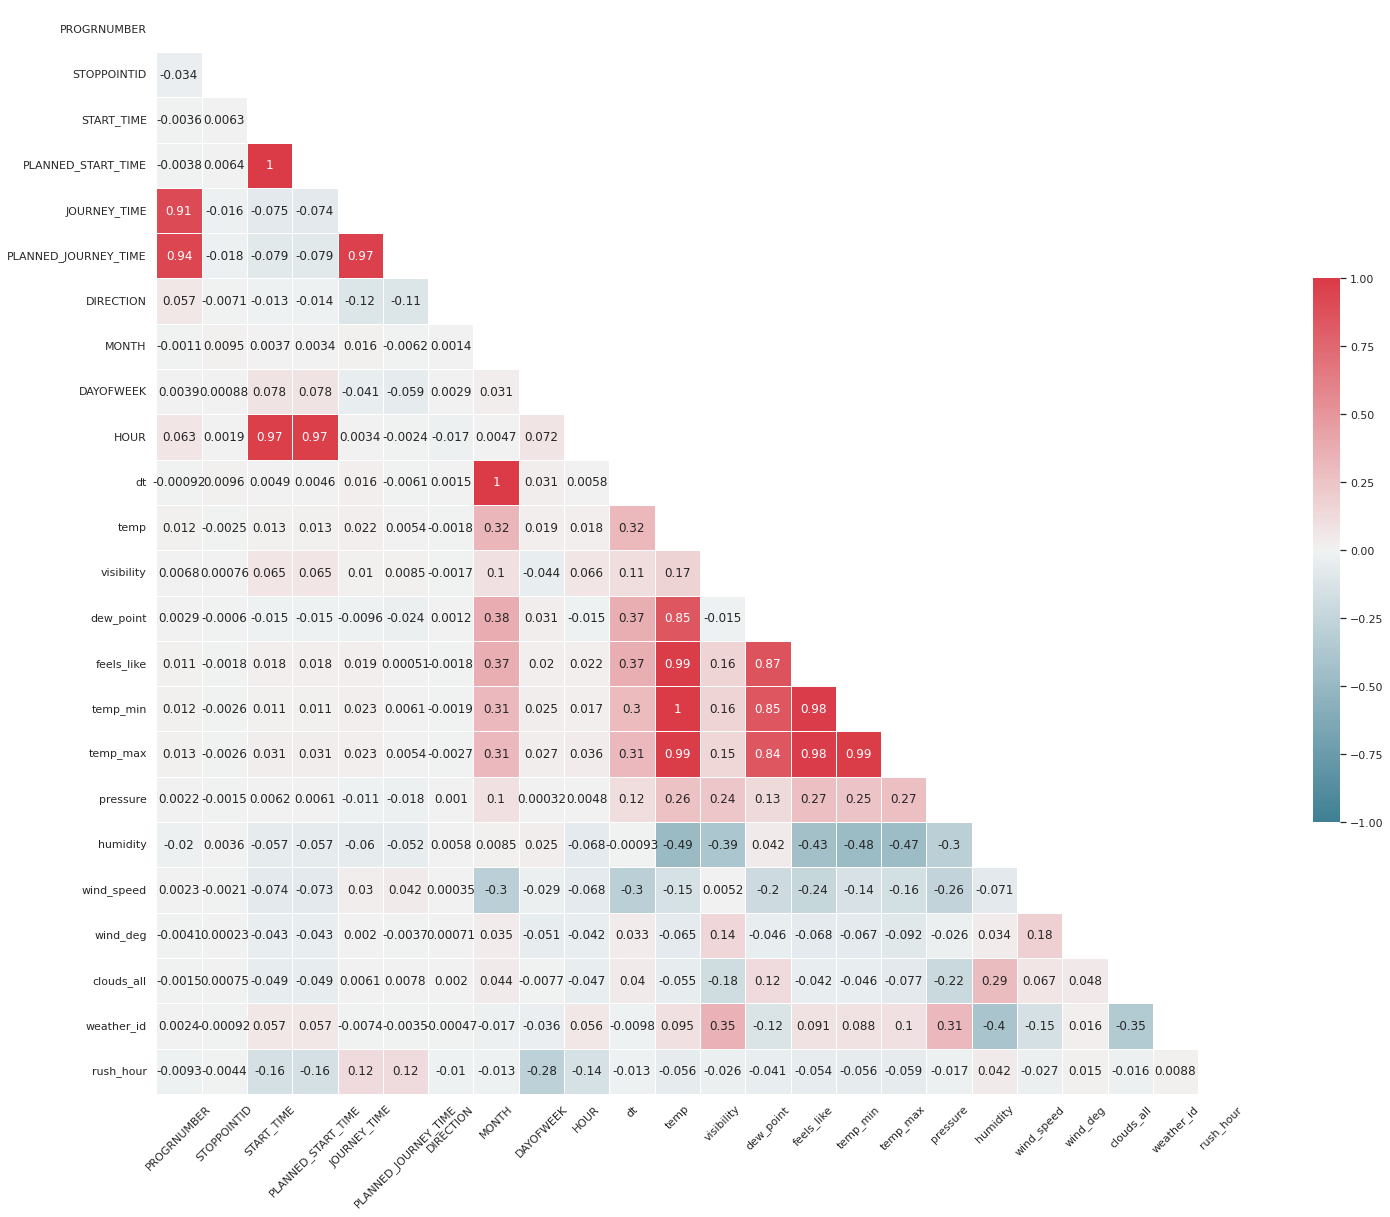

In [73]:
draw_correlations(test_46A)

In [74]:
# first way to encode journey time
# test_46A = test_46A.drop({'DAYOFSERVICE', "TRIPID", "PLANNEDTIME_ARR",'ACTUALTIME_ARR','LINEID','PRE_PROGRNUMBER','PRE_STOPPOINTID','PRE_PLANNEDTIME_ARR','PRE_ACTUALTIME_ARR','PLANNED_JOURNEY_TIME','STOP_INTERVAL','MONTH','DAYOFWEEK','HOUR','dt'}, axis=1)

In [75]:
# second way to encode journey
test_46A['weather_main'] = test_46A['weather_main'].apply(lambda x: 1 if (x == "Rain" or x == "Mist" or x == "Thunderstorm") else 0)
test_46A = test_46A.drop({'DAYOFSERVICE', 'LINEID', 'START_TIME','PLANNED_START_TIME','PLANNED_JOURNEY_TIME','dt','visibility','dew_point','feels_like','temp_min','temp_max','pressure','humidity','wind_deg','clouds_all','weather_id','weather_description','weather_icon','wind_speed','temp'}, axis=1)

In [76]:
# # dummy convert to categories
# categories = [feature for feature in list(test_46A.columns) if feature != 'PROGRNUMBER' and feature != 'STOPPOINTID' and feature != 'JOURNEY_TIME' and feature != 'PLANNED_JOURNEY_TIME' and feature != 'rush_hour' and feature != 'temp']
# for feature in categories:
#     test_46A[feature] = test_46A[feature].astype('category')

In [77]:
# categories

In [78]:
# test_46A['weather_main'] = test_46A['weather_main'].astype('category')

In [79]:
test_46A.dtypes

PROGRNUMBER     int64
STOPPOINTID     int64
JOURNEY_TIME    int64
DIRECTION       int64
MONTH           int64
DAYOFWEEK       int64
HOUR            int64
weather_main    int64
rush_hour       int64
dtype: object

In [80]:
### change data type to int16 to save space

In [81]:
numbers = [feature for feature in list(test_46A.columns)]
for feature in numbers:
    if feature != 'weather_main':
        test_46A[feature] = test_46A[feature].astype('int32')
    if feature == 'weather_main':
        test_46A[feature] = test_46A[feature].astype('category')

In [82]:
numbers

['PROGRNUMBER',
 'STOPPOINTID',
 'JOURNEY_TIME',
 'DIRECTION',
 'MONTH',
 'DAYOFWEEK',
 'HOUR',
 'weather_main',
 'rush_hour']

## Model training

In [83]:
test_46A[test_46A.isnull().T.any()]

,PROGRNUMBER,STOPPOINTID,JOURNEY_TIME,DIRECTION,MONTH,DAYOFWEEK,HOUR,weather_main,rush_hour


In [84]:
test_46A.dropna(axis=0, how='any', inplace=True)

## calculate loss function

In [85]:
def modelEvalucation(actualVal, predictions):
    #classification evaluation measures
    print("MAE: ", metrics.mean_absolute_error(actualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(actualVal, predictions))
    print("MAPE:", metrics.mean_absolute_percentage_error(actualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(actualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(actualVal, predictions))
    print("\n")

### Linear regression

In [86]:
MAPEs = []
R2 = []
X_train_size_avg = 0
X_test_size_avg = 0
dt = test_46A
y=dt["JOURNEY_TIME"] 
x=dt.drop('JOURNEY_TIME', axis=1)
features=x.columns.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
lg = LinearRegression()
lg.fit(X_train, y_train)

#add to avg size of train/test arrays
X_train_size_avg += X_train.shape[0]
X_test_size_avg += X_test.shape[0]
prediction = lg.predict(X_test)
#modelEvalucation(y_test, prediction)
MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
R2 += [metrics.r2_score(y_test, prediction)]


In [87]:
print(MAPEs)
print(R2)

[0.3749852894531496]
[0.8738961714384521]


### Random Forest

In [88]:
MAPEs = []
R2 = []
X_train_size_avg = 0
X_test_size_avg = 0
dt = test_46A
y=dt["JOURNEY_TIME"] 
x=dt.drop('JOURNEY_TIME', axis=1)
features=x.columns.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
rfc = RandomForestRegressor(n_estimators=10,n_jobs=-1, max_features='auto', random_state=90)
rfc.fit(X_train, y_train)

#add to avg size of train/test arrays
X_train_size_avg += X_train.shape[0]
X_test_size_avg += X_test.shape[0]
prediction = rfc.predict(X_test)
#modelEvalucation(y_test, prediction)
MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
R2 += [metrics.r2_score(y_test, prediction)]


/home/team9/miniconda3/envs/comp47360py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [89]:
print(MAPEs)
print(R2)

[0.1266007996960421]
[0.9413252091657024]


#### generate test pickle here

In [90]:
# f = open('test_46A.pickle','wb')
# pickle.dump(rfc,f)
# f.close()

### KNN


In [91]:
MAPEs = []
R2 = []
X_train_size_avg = 0
X_test_size_avg = 0
dt = test_46A
y=dt["JOURNEY_TIME"] 
x=dt.drop('JOURNEY_TIME', axis=1)
features=x.columns.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

#add to avg size of train/test arrays
X_train_size_avg += X_train.shape[0]
X_test_size_avg += X_test.shape[0]
prediction = knn.predict(X_test)
#modelEvalucation(y_test, prediction)
MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
R2 += [metrics.r2_score(y_test, prediction)]


In [92]:
print(MAPEs)
print(R2)

[0.13106383682792186]
[0.9366912573204241]


**The first way to encode journey time for closed stop, really low accuracy would be abandon:**  
linear:  
with journey time:  
dummy:  
mape: 0.4910280814156264  
r2: 0.39209881114889744  
cyclical:  
0.49210388700169494  
0.3803995783563362  
without journey time:  
mape: 0.8462704082541401  
r2: 0.0249582517569088  
dummy:  
mape: 0.4212289414532772  
r2: 0.4923778857956742  
cyclical:  
mape: 0.4187057418408166  
r2: 0.5057782636395496  

**Second way to encde journey time from start to the exact stop, much higher accuracy:**  
cyclical + without journey time:  
linear:  
MAPE: 0.477594681479744  
R2: 0.8637622845123674  
Random Forest:  
MAPE: 0.22104144123976383  
R2: 0.8979902559759351  
knn:  
0.22397472056619927  
0.8971929297420735  
dummy + without journey time:  
linear:  
0.48298623316589123  
0.8688107573016325  
random forest:  
0.2208579353936612  
0.8981466162068453  
knn:  
0.2230045491734964  
0.8995927202261019  

**no encoding time, sacrifice a little bit accuracy and increase the running time**  
linear:  
0.4549991852580995  
0.8427389391167591  
rf:  
0.21597044706180832 
0.897917008191297  
knn:  
0.21593485802443746  
0.9012100830467833  

### find the best estimator
don't think there is much difference, will choose the smaller estimator to control the pickle size and running time

In [ ]:
# # seems not too much difference
# estimators = [5, 10, 15, 20, 25, 30, 50]
# for i in estimators:
#     accuracy_estimators = []
#     print(f"average accuracy for {i} estimators")
#     MAPEs = []
#     R2 = []
#     dt = test_46A
#     y=dt["JOURNEY_TIME"] 
#     x=dt.drop('JOURNEY_TIME', axis=1)
#     features=x.columns.values.tolist()
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
#     rfc = RandomForestRegressor(n_estimators=i, n_jobs=-1, max_features='auto', random_state=90)
#     rfc.fit(X_train, y_train)
#     prediction = rfc.predict(X_test)
#     #modelEvalucation(y_test, prediction)
#     MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
#     R2 += [metrics.r2_score(y_test, prediction)]
#     print('MAPE: ',MAPEs)
#     print('R2: ', R2)

In [ ]:
# max_depth = [10, 20, 30, 40, 50, 60, 70]
# for i in estimators:
#     print(f"average accuracy for depth of {i} ")
#     MAPEs = []
#     R2 = []
#     dt = test_46A
#     y=dt["JOURNEY_TIME"] 
#     x=dt.drop('JOURNEY_TIME', axis=1)
#     features=x.columns.values.tolist()
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
#     rfc = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=i)
#     rfc.fit(X_train, y_train)
#     prediction = rfc.predict(X_test)
#     #modelEvalucation(y_test, prediction)
#     MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
#     R2 += [metrics.r2_score(y_test, prediction)]
#     print('MAPE: ',MAPEs)
#     print('R2: ', R2)

In [ ]:
# max_leaf_nodes = [75, 100, 125, 150, 200, 250, 300]
# for i in max_leaf_nodes:
#     print(f"average accuracy for {i} leaf nodes")
#     MAPEs = []
#     R2 = []
#     dt = test_46A
#     y=dt["JOURNEY_TIME"] 
#     x=dt.drop('JOURNEY_TIME', axis=1)
#     features=x.columns.values.tolist()
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
#     rfc = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=50, max_leaf_nodes=i)
#     rfc.fit(X_train, y_train)
#     prediction = rfc.predict(X_test)
#     #modelEvalucation(y_test, prediction)
#     MAPEs += [metrics.mean_absolute_percentage_error(y_test, prediction)]
#     R2 += [metrics.r2_score(y_test, prediction)]
#     print('MAPE: ',MAPEs)
#     print('R2: ', R2)

### test the usability of the pickle

In [2]:
cd tmp/data

/home/team9/tmp/data


In [4]:
# pickle testing
f = open('test_46A_copy.pkl', 'rb')
model = pickle.load(f)
print(model)

RandomForestRegressor(max_depth=34, max_leaf_nodes=125, min_samples_leaf=10,
                      n_estimators=30, n_jobs=-1)


In [5]:
data = {'PROGRNUMBER': 5,
 'STOPPOINTID': 2043,
 'DIRECTION': 2,
 'MONTH': 1,
 'DAYOFWEEK': 0,
 'HOUR': 11,
 'weather_main': 1,
 'rush_hour': 0}

In [6]:
df = pd.DataFrame([data])

In [7]:
print(df)

   PROGRNUMBER  STOPPOINTID  DIRECTION  MONTH  DAYOFWEEK  HOUR  weather_main  \
0            5         2043          2      1          0    11             1   

   rush_hour  
0          0  


In [8]:
y = model.predict(df)

In [9]:
print(y)

[347.98753055]
